In [1]:
import itertools
import numpy as np 

In [2]:
import sys
sys.path.append('../')
from setupPOMDP import *
from visualizeEnvironment import *
from ValueIteration import *

# Environments

In [3]:
# Actions correspond to E, N, W, S, Stay respectively
allActions = [(1,0), (0,1), (-1,0), (0,-1), (0,0)]

#all location states in grid
gridWidth = 5
gridHeight = 5
gridSet = set(itertools.product(range(gridWidth), range(gridHeight)))

#set of states to remove from each environment
barriersC = {(2,1), (3,1), (4,1)}


#final environment state sets
stateSetC = list(gridSet.difference(barriersC))

#goal locations
world1Goal = (0,4)
world2Goal = (4,4)


## Typical Transition with an incomplete state set

In [4]:
class SetupDeterministicTransition(object):
    def __init__(self, stateSet, actionSet):
        self.stateSet = stateSet
        self.actionSet = actionSet

    def __call__(self):
        transitionTable = {state: self.getStateTransition(state) for state in self.stateSet}
        return(transitionTable) 

    def getStateTransition(self, state):
        actionTransitionDistribution = {action: self.getStateActionTransition(state, action) for action in self.actionSet}
        return(actionTransitionDistribution)
    
    def getStateActionTransition(self, currentState, action):
        nextState = self.getNextState(currentState, action)
        
        #determinisitic transition
        transitionDistribution = {nextState: 1}
        return(transitionDistribution)

    
    def getNextState(self, state, action):
        potentialNextState = tuple([state[i] + action[i] for i in range(len(state))])
        if potentialNextState in self.stateSet:
            return(potentialNextState)
        return(state) 

In [5]:
getTransition = SetupDeterministicTransition(stateSetC, allActions)

# possible environment transitions
environmentCTransitionTable = getTransition()

## Belief Transition

In [6]:
class SetupBeliefTransition(object):
    def __init__(self, positionSet, beliefSet, actionSet, observationPositionSet):
        self.positionSet = positionSet
        self.beliefSet = beliefSet
        self.actionSet = actionSet
        self.observationPositionSet = observationPositionSet

    def __call__(self, world):
        beliefTransition = {(position, belief): {action: self.getNewBeliefOfAction(position, belief, action, world)\
                             for action in self.actionSet} \
         for position in self.positionSet \
         for belief in self.beliefSet}
        return(beliefTransition)
        
    def getNewBeliefOfAction(self, position, belief, action, world):
        observation = self.getObservation(position, action, world)
        newBelief = np.sign(belief + observation)
        
        newPosition = self.getNextPosition(position, action)
        newBeliefDictionary = {(newPosition, newBelief):1}
        return(newBeliefDictionary)
    
    def getObservation(self, position, action, world):
        nextPosition = self.getNextPosition(position, action)
        if nextPosition in self.observationPositionSet:
            return(world)
        return(0)
    
    def getNextPosition(self, position, action):
        potentialNextState = tuple([position[i] + action[i] for i in range(len(position))])
        if potentialNextState in self.positionSet:
            return(potentialNextState)
        return(position) 

In [7]:
positionSet = stateSetC
beliefSet = [-1,0,1]  
observeSign = [(0,0), (1,0), (2,0), (3,0), (4,0)]
world1 = 2
world2 = -2

In [8]:
getBeliefTransition = SetupBeliefTransition(positionSet, beliefSet, allActions, observeSign)

# possible environment transitions
beliefTransitionTable = getBeliefTransition(world2)

In [9]:
viewDictionaryStructure(beliefTransitionTable, levelsTransition)

state: ((3, 2), -1)
	action: (1, 0)
		next state: ((4, 2), -1)
			probability: 1
	action: (0, 1)
		next state: ((3, 3), -1)
			probability: 1
	action: (-1, 0)
		next state: ((2, 2), -1)
			probability: 1
	action: (0, -1)
		next state: ((3, 2), -1)
			probability: 1
	action: (0, 0)
		next state: ((3, 2), -1)
			probability: 1
state: ((3, 2), 0)
	action: (1, 0)
		next state: ((4, 2), 0)
			probability: 1
	action: (0, 1)
		next state: ((3, 3), 0)
			probability: 1
	action: (-1, 0)
		next state: ((2, 2), 0)
			probability: 1
	action: (0, -1)
		next state: ((3, 2), 0)
			probability: 1
	action: (0, 0)
		next state: ((3, 2), 0)
			probability: 1
state: ((3, 2), 1)
	action: (1, 0)
		next state: ((4, 2), 1)
			probability: 1
	action: (0, 1)
		next state: ((3, 3), 1)
			probability: 1
	action: (-1, 0)
		next state: ((2, 2), 1)
			probability: 1
	action: (0, -1)
		next state: ((3, 2), 1)
			probability: 1
	action: (0, 0)
		next state: ((3, 2), 1)
			probability: 1
state: ((1, 3), -1)
	action: (1

In [10]:
st = ((1,0),-1)
a = (-1,0)
beliefTransitionTable[st][a]

{((0, 0), -1): 1}

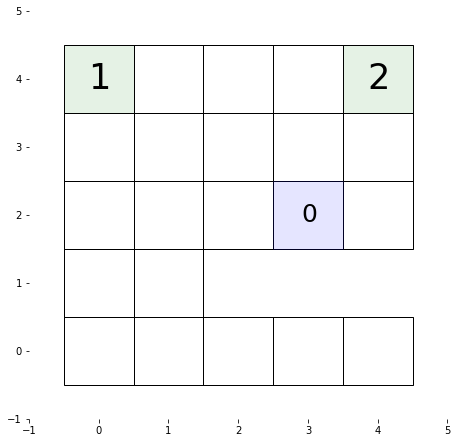

In [11]:
visualizeEnvironment(gridWidth = gridWidth, gridHeight = gridHeight, states = stateSetC, \
                     goalStates = [(0,4, "1"), (4,4, "2")], trajectory = [(3,2)])

# Reward

## Typical Reward - State action based

In [12]:
class StateActionRewardTableWithDistanceMoveCost(object):
    def __init__(self, stateSet, actionSet, goalStates = [], trapStates = []):
        self.stateSet = stateSet
        self.actionSet = actionSet
        self.goalStates = goalStates
        self.trapStates = trapStates
        
    def __call__(self, goalReward = 10, trapCost = -100):
        rewardTable = {state: {action: self.applyRewardFunction(state, action, goalReward, trapCost) \
                               for action in self.actionSet} \
                       for state in self.stateSet}
        return(rewardTable)

    def applyRewardFunction(self, state, action, goalReward, trapCost):
        moveCost = self.getMoveCost(action)
        
        if state in self.goalStates:
            return(goalReward+moveCost)
        elif state in self.trapStates:
            return(trapCost)
        return(moveCost)
    
    def getMoveCost(self, action):
        if action == (0,0):
            return(-.1)
        else:
            actionDistance = sum([abs(action[i]) for i in range(len(action))])
            return(-actionDistance)

In [13]:
getWorld1Reward = StateActionRewardTableWithDistanceMoveCost(stateSetC, allActions, [world1Goal], [world2Goal])
rewardofWorld1 = getWorld1Reward()

getWorld2Reward = StateActionRewardTableWithDistanceMoveCost(stateSetC, allActions,[world2Goal], [world1Goal])
rewardofWorld2 = getWorld2Reward()

In [14]:
rewardofWorld2

{(3, 2): {(1, 0): -1, (0, 1): -1, (-1, 0): -1, (0, -1): -1, (0, 0): -0.1},
 (1, 3): {(1, 0): -1, (0, 1): -1, (-1, 0): -1, (0, -1): -1, (0, 0): -0.1},
 (0, 0): {(1, 0): -1, (0, 1): -1, (-1, 0): -1, (0, -1): -1, (0, 0): -0.1},
 (3, 0): {(1, 0): -1, (0, 1): -1, (-1, 0): -1, (0, -1): -1, (0, 0): -0.1},
 (1, 4): {(1, 0): -1, (0, 1): -1, (-1, 0): -1, (0, -1): -1, (0, 0): -0.1},
 (1, 1): {(1, 0): -1, (0, 1): -1, (-1, 0): -1, (0, -1): -1, (0, 0): -0.1},
 (2, 3): {(1, 0): -1, (0, 1): -1, (-1, 0): -1, (0, -1): -1, (0, 0): -0.1},
 (4, 2): {(1, 0): -1, (0, 1): -1, (-1, 0): -1, (0, -1): -1, (0, 0): -0.1},
 (0, 3): {(1, 0): -1, (0, 1): -1, (-1, 0): -1, (0, -1): -1, (0, 0): -0.1},
 (1, 0): {(1, 0): -1, (0, 1): -1, (-1, 0): -1, (0, -1): -1, (0, 0): -0.1},
 (2, 4): {(1, 0): -1, (0, 1): -1, (-1, 0): -1, (0, -1): -1, (0, 0): -0.1},
 (4, 0): {(1, 0): -1, (0, 1): -1, (-1, 0): -1, (0, -1): -1, (0, 0): -0.1},
 (1, 2): {(1, 0): -1, (0, 1): -1, (-1, 0): -1, (0, -1): -1, (0, 0): -0.1},
 (0, 1): {(1, 0): -1, (0,

## Belief Reward Rho

In [15]:
class SetupRewardBeliefTable(object):
    def __init__(self, positionSet, beliefSet, actionSet):
        self.positionSet = positionSet
        self.beliefSet = beliefSet
        self.actionSet = actionSet
        
    def __call__(self, beliefTransition, worldRewardList):
        rewardTable = {(position, worldBelief): {action: {nextState:
                        self.getRewardBelief(position, self.getProbabilityWorld1(worldBelief), action, worldRewardList) \
                                                         for nextState in beliefTransition[(position, worldBelief)][action].keys()}\
                             for action in self.actionSet} \
         for position in self.positionSet \
         for worldBelief in self.beliefSet}
        return(rewardTable)
    
    def getProbabilityWorld1(self, worldBelief):
        if worldBelief < 0:
            return(0)
        elif worldBelief > 0:
            return(1)
        return(.5)
    
    def getRewardBelief(self, position, probWorld1, action, worldRewards):
        rewardBelief = probWorld1*worldRewards[0][position][action] \
        + (1-probWorld1)*worldRewards[1][position][action]
        return(rewardBelief)


In [16]:
getRewardBeliefs = SetupRewardBeliefTable(positionSet, beliefSet, allActions)
reward = getRewardBeliefs(beliefTransitionTable, [rewardofWorld1, rewardofWorld2])

In [17]:
viewDictionaryStructure(reward, ["state", "action", "nextState", "reward"])

state: ((3, 2), -1)
	action: (1, 0)
		nextState: ((4, 2), -1)
			reward: -1
	action: (0, 1)
		nextState: ((3, 3), -1)
			reward: -1
	action: (-1, 0)
		nextState: ((2, 2), -1)
			reward: -1
	action: (0, -1)
		nextState: ((3, 2), -1)
			reward: -1
	action: (0, 0)
		nextState: ((3, 2), -1)
			reward: -0.1
state: ((3, 2), 0)
	action: (1, 0)
		nextState: ((4, 2), 0)
			reward: -1.0
	action: (0, 1)
		nextState: ((3, 3), 0)
			reward: -1.0
	action: (-1, 0)
		nextState: ((2, 2), 0)
			reward: -1.0
	action: (0, -1)
		nextState: ((3, 2), 0)
			reward: -1.0
	action: (0, 0)
		nextState: ((3, 2), 0)
			reward: -0.1
state: ((3, 2), 1)
	action: (1, 0)
		nextState: ((4, 2), 1)
			reward: -1
	action: (0, 1)
		nextState: ((3, 3), 1)
			reward: -1
	action: (-1, 0)
		nextState: ((2, 2), 1)
			reward: -1
	action: (0, -1)
		nextState: ((3, 2), 1)
			reward: -1
	action: (0, 0)
		nextState: ((3, 2), 1)
			reward: -0.1
state: ((1, 3), -1)
	action: (1, 0)
		nextState: ((2, 3), -1)
			reward: -1
	action: (0, 1)


In [43]:
x =None

if not x:
    print("Y")
    

Y


# Value Iteration

In [19]:
valueTable = {state:0 for state in beliefTransitionTable.keys()}

getPolicyA = BoltzmannValueIteration(beliefTransitionTable, reward, valueTable, 10e-7, .9, .8)
optimalValuesA, policyA = getPolicyA()

In [20]:
policyA[((0,1), 1)]

{(1, 0): 5.652783918087756e-06,
 (0, 1): 0.9947235642565326,
 (-1, 0): 0.0017256173554775142,
 (0, -1): 1.1532494184312812e-13,
 (0, 0): 0.00354516560395648}

In [21]:
def visualizePolicy(gridWidth, gridHeight, states, goalStates, trapStates, policy, belief, trajectory = [], arrowScale = .3):
    gridAdjust = .5
    gridScale = 1.5
    
    xs = np.linspace(-gridAdjust, gridWidth-gridAdjust, gridWidth+1)
    ys = np.linspace(-gridAdjust, gridHeight-gridAdjust, gridHeight+1)
    
    plt.rcParams["figure.figsize"] = [gridWidth*gridScale,gridHeight*gridScale]
    ax = plt.gca(frameon=False, xticks = range(-1, gridWidth+1), yticks = range(-1, gridHeight+1))

    #goal and trap coloring 
    for (goalx,goaly) in goalStates:
        ax.add_patch(Rectangle((goalx-gridAdjust, goaly-gridAdjust), 1, 1, fill=True, color='green', alpha=.1))
    for (trapx, trapy) in trapStates:
        ax.add_patch(Rectangle((trapx-gridAdjust, trapy-gridAdjust), 1, 1, fill=True, color='red', alpha=.1))

    #gridline drawing
    for (statex, statey) in states:
        ax.add_patch(Rectangle((statex-gridAdjust, statey-gridAdjust), 1, 1, fill=False, color='black', alpha=1))

    #trajectory path coloring
    for indx, (statex, statey) in enumerate(trajectory):
        ax.add_patch(Rectangle((statex-gridAdjust, statey-gridAdjust), 1, 1, fill=True, color='blue', alpha=.1))
        ax.text(statex-.1, statey-.1, str(indx), fontsize = 25)

    #labeled values
    for ((statex, statey), b) in policy.keys():
        if b == belief:
            for (actionx, actiony), actionProb in policy[((statex, statey), b)].items():
                plt.arrow(statex, statey, actionx*actionProb*arrowScale, actiony*actionProb*arrowScale, head_width=0.05*actionProb, head_length=0.1*actionProb)    
    plt.show()

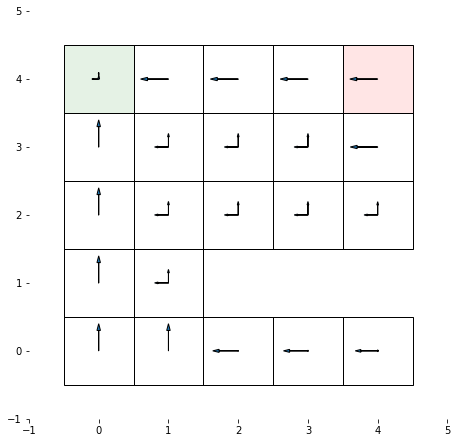

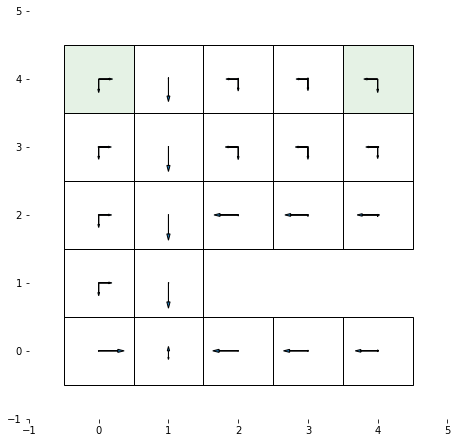

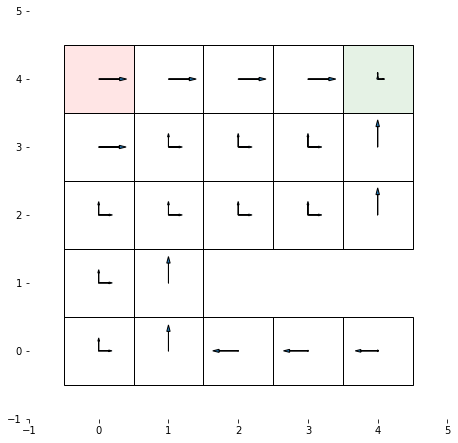

In [22]:
visualizePolicy(gridWidth, gridHeight, positionSet, [(0,4)], [(4,4)], policyA, 1)
visualizePolicy(gridWidth, gridHeight, positionSet, [(0,4),(4,4)], [], policyA, 0)
visualizePolicy(gridWidth, gridHeight, positionSet, [(4,4)], [(0,4)], policyA, -1)

In [23]:
policyA[(1,1), -1]

{(1, 0): 0.009431533757260739,
 (0, 1): 0.9709007511127423,
 (-1, 0): 0.00014562947588568983,
 (0, -1): 0.00014562947588568983,
 (0, 0): 0.01937645617822537}

In [24]:
def samplePathToGoal(position, belief, policy, transition, goals):
    trajectory = [(position, belief)]

    while position not in goals:
        #take action probabilisitically
        actions = list(policy[(position, belief)].keys())
        probOfAction = [policy[(position, belief)][action] for action in actions]
        actionIndex = np.random.choice(len(actions), 1, p = probOfAction)
        sampledAction = actions[int(actionIndex)]
        
        #get new position and belief
        newPosition = list(transition[(position, belief)][sampledAction].keys())[0][0]
        newBelief = list(transition[(position, belief)][sampledAction].keys())[0][1]
        
        #update to new belief/position and add to trajectory
        belief = newBelief
        position = newPosition
        trajectory.append((position, belief))
    return(trajectory)

In [25]:
#np.random.seed(127)
path = samplePathToGoal((3,2), 0, policyA, beliefTransitionTable, [(0,4), (4,4)])
positionTrajectory = [pos for pos, belief in path]

In [26]:
policyA[((2,2), 0)]

{(1, 0): 0.002688940515050788,
 (0, 1): 0.002688940515050788,
 (-1, 0): 0.8678780687454667,
 (0, -1): 0.041495112671890294,
 (0, 0): 0.08524893755254136}

In [27]:
positionTrajectory

[(3, 2),
 (2, 2),
 (2, 2),
 (1, 2),
 (1, 1),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 4),
 (3, 4),
 (4, 4)]

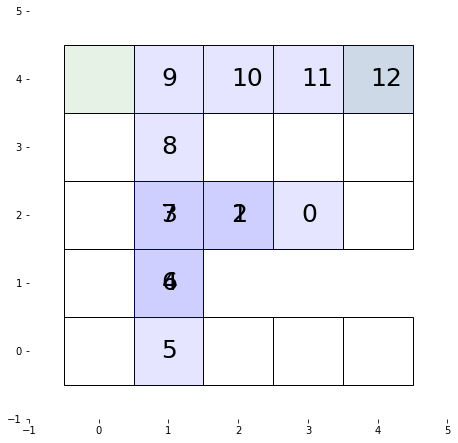

In [28]:
visualizeEnvironment(gridWidth = gridWidth, gridHeight = gridHeight, states = stateSetC, \
                     goalStates = [(0,4, " "), (4,4, " ")], trajectory = positionTrajectory)